In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from mnist_dataset import Dataset

import matplotlib.pyplot as plt

In [9]:
class GAN:
    
    def __init__(self, x_size, z_size):
        self.x_size = x_size
        self.z_size = z_size
        
        self.__build()
    
    def __build(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.__placeholders()
            
            g_model = self.__get_generator(self.z)
            
            real_logits = self.__get_discriminator(self.X)
            fake_logits = self.__get_discriminator(g_model, True)
            
            # building the loss function
            real_loss = -tf.reduce_mean(tf.log_sigmoid(real_logits))
            fake_loss = -tf.reduce_mean(tf.log_sigmoid(-fake_logits))
            
            self.loss_disc = real_loss + fake_loss
            self.loss_gen = -tf.reduce_mean(tf.log_sigmoid(fake_logits))
            
            # building the optimizer
            t_vars = tf.trainable_variables()
            g_vars = [var for var in t_vars if 'generator' in var.name]
            d_vars = [var for var in t_vars if 'discriminator' in var.name]
            
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                self.opt_gen = tf.train.AdamOptimizer(self.eta, .5).minimize(self.loss_gen, var_list=g_vars)
                self.opt_disc = tf.train.AdamOptimizer(self.eta, .5).minimize(self.loss_disc, var_list=d_vars)
            
            self.generator = self.__get_generator(self.z, True)
    
    def __get_generator(self, tensor, reuse=False):
        with tf.variable_scope('generator', reuse=reuse):
            tensor = tf.layers.dense(tensor, 250)
            tensor = self.__add_batch_normalization(tensor, tf.nn.tanh)
            
            tensor = tf.layers.dense(tensor, 500)
            tensor = self.__add_batch_normalization(tensor, tf.nn.tanh)
            
            return tf.layers.dense(tensor, self.x_size, activation=tf.nn.tanh)
    
    def __get_discriminator(self, tensor, reuse=False):
        with tf.variable_scope('discriminator', reuse=reuse):
            tensor = tf.layers.dense(tensor, 500, tf.nn.relu) 
            tensor = tf.layers.dense(tensor, 250, tf.nn.relu)
            
            return tf.layers.dense(tensor, 1)
    
    def __placeholders(self):
        self.X = tf.placeholder(tf.float32, [None, x_size], name='X')
        self.z = tf.placeholder(tf.float32, [None, z_size], name='z')
        
        self.eta = tf.placeholder(tf.float32, name='eta')
        self.is_training = tf.placeholder(tf.bool, name='is_training')
    
    def __add_batch_normalization(self, tensor, activation=None):
        tensor = tf.layers.batch_normalization(tensor, training=self.is_training)
        return activation(tensor)

In [3]:
dataset = Dataset('mnist_dataset/')

In [10]:
x_size = 784
z_size = 100

model = GAN(x_size, z_size)
model_name = 'mnist_vanilla'

epochs = 10

train_size = len(dataset.train['images'])
batch_size = 100

with tf.Session(graph=model.graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
#     saver.restore(sess, f'./models/{model_name}')
    
    print('Starting!')
    dl, gl = list(), list()
    for epoch in range(epochs):
        dlosses, glosses = list(), list()
        for _ in range(train_size//batch_size):
            X, _ = dataset.next_batch(batch_size)
            
            feed_dict = dict()
            feed_dict[model.X] = X*2 - 1
            feed_dict[model.z] = np.random.randn(batch_size, z_size)
            feed_dict[model.eta] = 3e-3
            feed_dict[model.is_training] = True
            
            dloss, _ = sess.run([model.loss_disc, model.opt_disc], feed_dict)

            feed_dict[model.z] = np.random.randn(batch_size, z_size)
            gloss, _ = sess.run([model.loss_gen, model.opt_gen], feed_dict)
            
            dlosses.append(dloss); glosses.append(gloss);
            
            print(f'\rEpoch: {epoch+1:3}/{epochs:3} - Disc: {dloss:.5f} - Gen: {gloss:.5}', end='')
        dloss = np.mean(dlosses)
        gloss = np.mean(glosses)
        dl.append(dloss); gl.append(gloss);
        print(f'\rEpoch: {epoch+1:3}/{epochs:3} - Disc: {dloss:.5f} - Gen: {gloss:.5}')
    
    saver.save(sess, f'./models/{model_name}')

Starting!
Epoch:   1/ 10 - Disc: 1.83319 - Gen: 1.5626
Epoch:   2/ 10 - Disc: 1.11999 - Gen: 1.1344
Epoch:   3/ 10 - Disc: 0.76362 - Gen: 1.8467
Epoch:   4/ 10 - Disc: 0.58664 - Gen: 2.2495
Epoch:   5/ 10 - Disc: 0.58178 - Gen: 2.3934
Epoch:   6/ 10 - Disc: 0.78708 - Gen: 1.8657
Epoch:   7/ 10 - Disc: 0.90155 - Gen: 1.5806
Epoch:   8/ 10 - Disc: 0.89301 - Gen: 1.5771
Epoch:   9/ 10 - Disc: 0.92466 - Gen: 1.5342
Epoch:  10/ 10 - Disc: 0.96672 - Gen: 1.4505


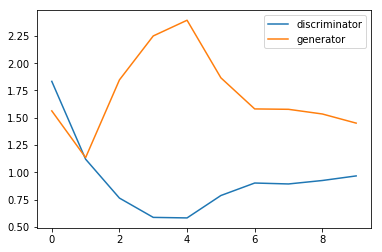

In [11]:
plt.plot(range(len(dl)), dl, label='discriminator')
plt.plot(range(len(gl)), gl, label='generator')
plt.legend()

In [17]:
x_size = 784
z_size = 100

model = GAN(x_size, z_size)
model_name = 'mnist_vanilla'

with tf.Session(graph=model.graph) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, f'./models/{model_name}')
    
    feed_dict = dict()
    feed_dict[model.z] = np.random.randn(25, z_size)
    feed_dict[model.is_training] = False

    img = sess.run(model.generator, feed_dict)
    img += 1
    img /= 2
    img = img.reshape(5, 5, 28, 28)

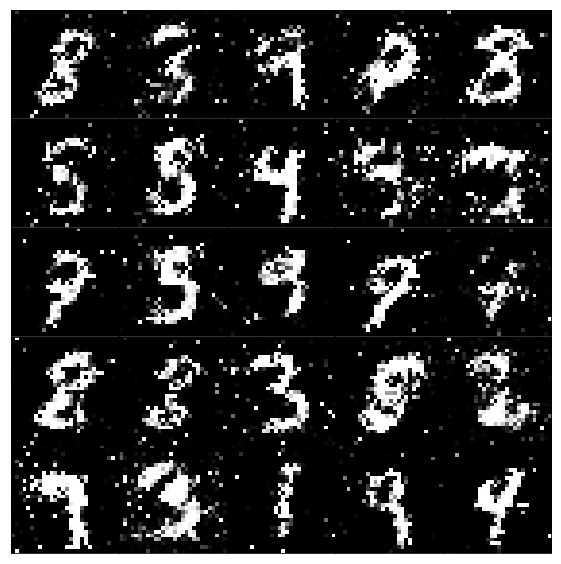

In [28]:
f, axs = plt.subplots(5, 5, figsize=(15, 10), sharex=True, sharey=True)
f.subplots_adjust(wspace=.0, hspace=.0, left=.0, right=.5)

for i, col in enumerate(axs):
    for j, ax in enumerate(col):
        ax.imshow(img[i, j], 'gray')
        ax.set_xticks([])
        ax.set_yticks([])